In [1]:
import pandas as pd
import torch
import numpy as np
from torch.utils.data import DataLoader

#%load_ext line_profiler

In [2]:
from model.eGauss_plus import eGAUSSp

In [3]:
# Load the dataset
file_path = 'Datasets/creditcard.csv'
data = pd.read_csv(file_path)


In [4]:
from utils.utils_dataset import balance_dataset
from utils.utils_dataset import prepare_dataset

device =  torch.device("cpu")# torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_clients = 3

proportion = 1
data = balance_dataset(data, proportion)
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values
client_train, test_data, all_data = prepare_dataset(X, y, num_clients, smote = False) 


In [5]:
# Model parameters
local_model_params = {
    "feature_dim": 30,
    "num_classes": 2,
    "kappa_n": 1,
    "num_sigma": 2,
    "kappa_join": 0.6,
    "S_0": 1e-8,
    "c_max": 1,
    "device": device
}

federated_model_params = {
    "feature_dim": 30,
    "num_classes": 2,
    "kappa_n": 1,
    "num_sigma": 2,
    "kappa_join": 1.1,
    "S_0": 1e-8,
    "c_max": 1,
    "device": device
}

# Initialize a model for each client
local_models = [eGAUSSp(**local_model_params) for _ in range(num_clients)]
federated_model = eGAUSSp(**federated_model_params)

In [6]:
from utils.utils_dataset import prepare_non_iid_dataset, plot_dataset_split, display_dataset_split

display_dataset_split(client_train, test_data)
#plot_dataset_split(client_train, test_data)

Client 1: {0: 115, 1: 115}
Client 2: {0: 106, 1: 123}
Client 3: {0: 114, 1: 115}
Test Set: {0: 157, 1: 139}

Combined Number of Samples per Class:
Class 0: 492 samples
Class 1: 492 samples

Total Number of Samples Across All Datasets: 984


In [7]:
import utils.utils_train
from utils.utils_train import train_supervised
from utils.utils_plots import plot_first_feature
from utils.utils_metrics import calculate_metrics, plot_confusion_matrix, calculate_roc_auc

import cProfile
%load_ext line_profiler

if False:


    # Assuming models and client_data are already defined
    #for client_idx, client_model in enumerate(local_models):
    
    data, labels = client_train[0]
    
    model = local_models[0]
    pr = cProfile.Profile()
    pr.enable()
    train_supervised(model, client_train[0])
    pr.disable()
    pr.print_stats(sort='cumtime')

#plot_first_feature(client_train[client_idx], model=client_model, num_sigma=2, N_max=1)  



In [8]:
if False:
       data, labels = client_train[0]
       model = local_models[0]

       %lprun -f model.forward\
              -f model.merging_mech.compute_kappa_matrix \
              -f model.merging_mech.merging_mechanism \
              -f model.merging_mech.update_merging_condition \
              -f model.merging_mech.compute_merging_condition\
              -f model.merging_mech.perform_merge\
              train_supervised(model, client_train[0])

In [9]:
import utils.utils_train
from utils.utils_train import train_supervised, train_models_in_threads
from utils.utils_plots import plot_first_feature

# Assuming local_models and client_train are already defined
# local_models is a list of models, client_train is a list of corresponding training datasets
train_models_in_threads(local_models, client_train, debugging = False)


Debugging has been disabled.
Evolving has been enabled.
Debugging has been disabled.
Evolving has been enabled.
Debugging has been disabled.
Evolving has been enabled.


In [10]:
from utils.utils_train import test_model   

# Testing each client's model on the global test dataset
if False:
    for client_idx, client_model in enumerate(local_models):
        print(f"\nTesting model for client {client_idx + 1}")
        all_scores, pred_max = test_model(client_model, test_data)
        metrics = calculate_metrics(pred_max, test_data)
        #test_model(client_model, all_data)
        print(f"Test Metrics: {metrics}")
        
    

In [11]:
for client_idx, client_model in enumerate(local_models):
        print(f"Merging client {client_idx + 1}")
        print(f"Number of client {client_idx + 1} clusters before merging = {torch.sum(client_model.n[:client_model.c]>client_model.kappa_n)}")
        client_model.federal_agent.federated_merging() 
        print(f"Number of client {client_idx + 1} after merging = {torch.sum(client_model.n[:client_model.c]>client_model.kappa_n)}")
        federated_model.federal_agent.merge_model_privately(client_model, client_model.kappa_n)

print(f"Number of clusters after transfer = {federated_model.c}")

Merging client 1
Number of client 1 clusters before merging = 33
Number of client 1 after merging = 26
Merging client 2
Number of client 2 clusters before merging = 28
Number of client 2 after merging = 12
Merging client 3
Number of client 3 clusters before merging = 31
Number of client 3 after merging = 17
Number of clusters after transfer = 55


In [12]:
from utils.utils_train import test_model

federated_model.federal_agent.federated_merging()
federated_model.removal_mech.removal_mechanism()
print(f"Number of clusters after merging = {federated_model.c}")

Number of clusters after merging = 21


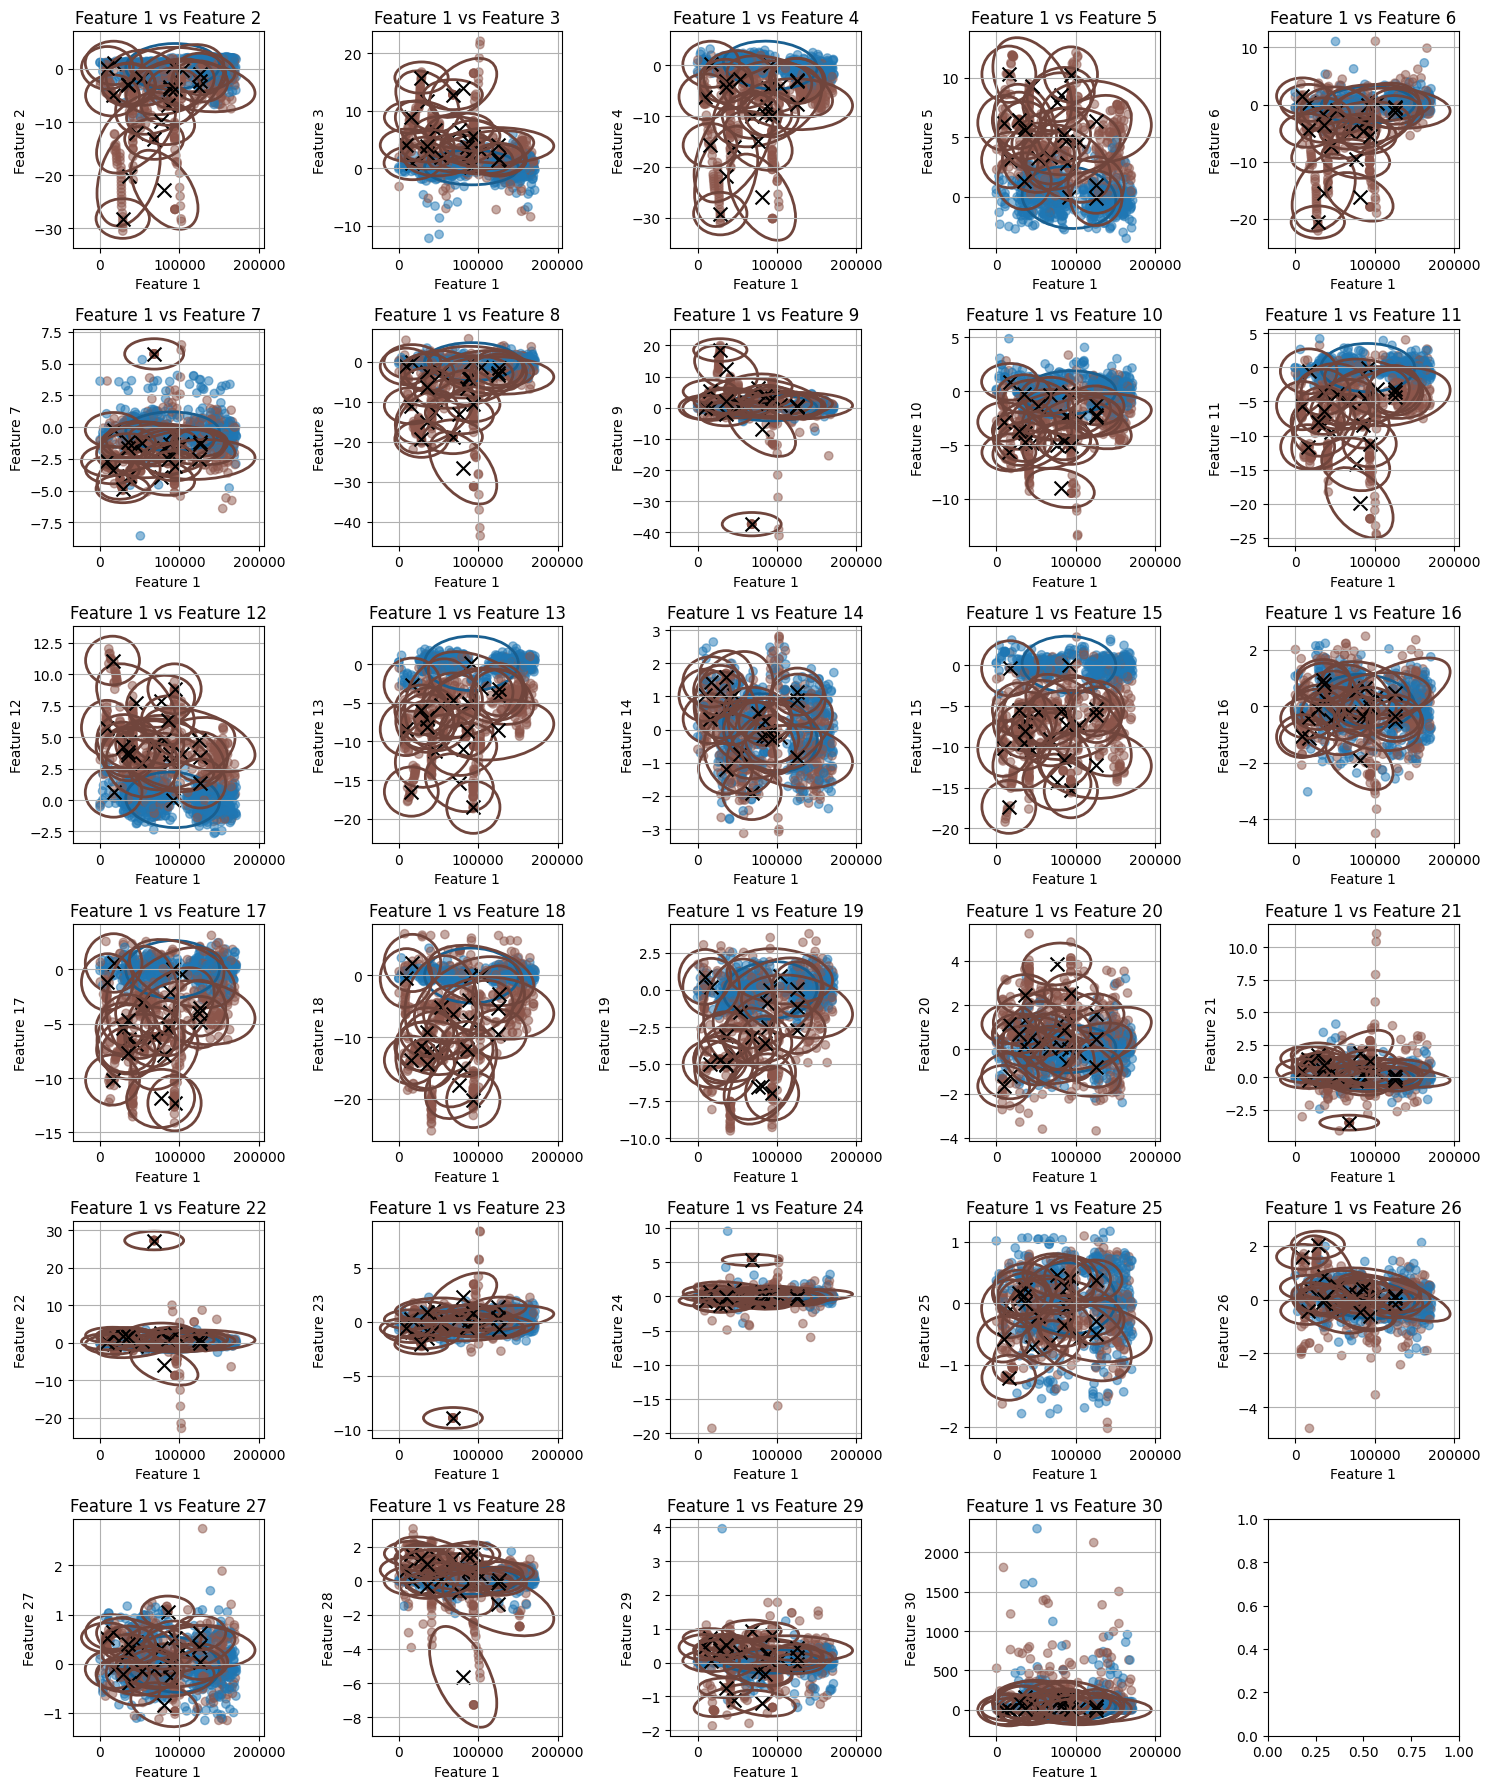

In [13]:

plot_first_feature(all_data, model=federated_model, num_sigma=federated_model.num_sigma, N_max=1)   


Testing federated model
Evolving has been disabled.
Test Metrics: {'accuracy': 0.9256756756756757, 'precision': 0.927007299270073, 'recall': 0.9136690647482014, 'f1_score': 0.9202898550724637}


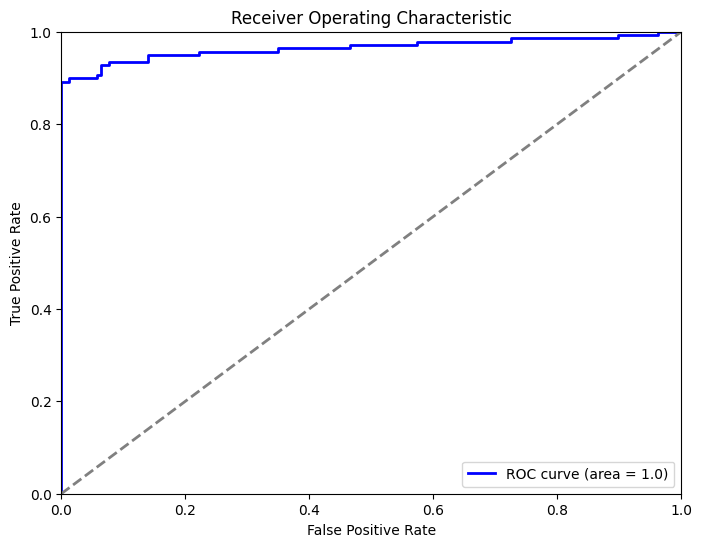

Test ROC AUC: 0.9653576501855841


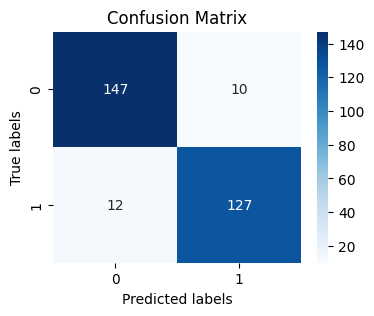

In [14]:


print(f"\nTesting federated model")   

all_scores, pred_max, _ = test_model(federated_model, test_data)
metrics = calculate_metrics(pred_max, test_data, "binary")
print(f"Test Metrics: {metrics}")
roc_auc = calculate_roc_auc(all_scores, test_data)
print(f"Test ROC AUC: {roc_auc}")

plot_confusion_matrix(pred_max, test_data)

In [15]:

'''
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Confusion matrix values
tn = 135
fn = 10
tp = 132
fp = 19

# Creating the confusion matrix
y_true = [0]*tn + [1]*fn + [1]*tp + [0]*fp  # 0 for negative class, 1 for positive class
y_pred = [0]*(tn+fn) + [1]*(fp+tp)  # Predictions

# Calculating metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(accuracy, precision, recall, f1)
'''

'\nfrom sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score\n\n# Confusion matrix values\ntn = 135\nfn = 10\ntp = 132\nfp = 19\n\n# Creating the confusion matrix\ny_true = [0]*tn + [1]*fn + [1]*tp + [0]*fp  # 0 for negative class, 1 for positive class\ny_pred = [0]*(tn+fn) + [1]*(fp+tp)  # Predictions\n\n# Calculating metrics\naccuracy = accuracy_score(y_true, y_pred)\nprecision = precision_score(y_true, y_pred)\nrecall = recall_score(y_true, y_pred)\nf1 = f1_score(y_true, y_pred)\n\nprint(accuracy, precision, recall, f1)\n'